In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("C:/Users/subha/Documents/winequality-red.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


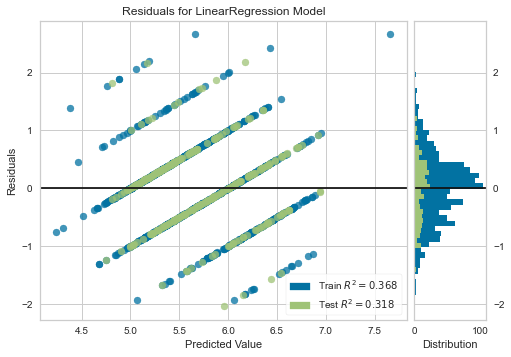

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [5]:
# Let's start by just running a simple linear regression to see what we get
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot

X = df.iloc[:, :-1]
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model_lin = LinearRegression()
vis = ResidualsPlot(model_lin)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

Pretty bad scores, and quality can only take on a few values (leading to diagonal lines). Could try more continuous regression techniques such as polynomial regression, but this will likely start to fit noise. The quality is discrete, so why don't we try classification?

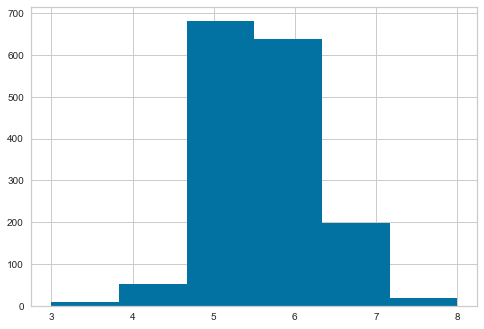

In [6]:
# let's take a look at the data first
y.hist(bins = 6);

In [7]:
# let's start with support vector machines, always a good place to start classification

from sklearn import svm
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_cat_tr = y_train.astype("category")
y_cat_te = y_test.astype("category")
model_svm = svm.SVC(kernel = 'rbf') #radial basis function kernel, continuous
model_svm.fit(X_train, y_cat_tr)
y_pred = model_svm.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_cat_te, y_pred))

Accuracy: 0.51875


In [8]:
# now let's try simple logistic classification which should perform slightly better because data is not purely categorical
# to spice it up a bit, we can also use cross validation this time to measure accuracy

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# evaluate the model and collect the scores
n_scores = cross_val_score(model_log, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: ', np.mean(n_scores))

Accuracy:  0.5830778301886792


Accuracy is still not great...Importantly, quality is an ordinal scale, not a categorical one, where the main distinction between wines is higher quality vs lower quality. This calls for something more exciting... ordinal regression!

In [9]:
# python has a great package called mord to help with ordinal regression
# let's compare all the models we have so far
import mord
from mord import LogisticIT
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_ord = LogisticIT(alpha = 0) # no regularization needed as high volume of data
mae = make_scorer(mean_absolute_error)
error1 = cross_val_score(model_ord, X, y, cv=5, scoring = mae)
error2 = cross_val_score(model_log, X, y, cv=5, scoring = mae)
error3 = cross_val_score(model_svm, X, y, cv=5, scoring = mae)
error4 = cross_val_score(model_lin, X, y, cv=5, scoring = mae)

print("Errors:")
print("Ordinal: ",np.mean(error1))
print("Logistic:",np.mean(error2))
print("SVM:     ",np.mean(error3))
print("Linear:  ",np.mean(error4))

Errors:
Ordinal:  0.4465086206896552
Logistic: 0.4696492946708464
SVM:      0.5609952978056426
Linear:   0.5104055782302341


It appears we've gotten the lowest absolute error with ordinal regression. Success! Admiteddly even 0.447 is not great, but it's good for the simple things we've done so far. Can possibly extend this with polynomial features and maybe some kernel methods (support vector ordinal regression?)